#**CONTENUTO DEL NOTEBOOK**

* Setting per Texture analyis
* Estrazione delle features
* Creazione dei Dataframes
* feature selection con test U di Mann Whitney
* standardizzazione delle feature selezionate
* PCA 2D 
* features più significative
* esclusione degli outliers (mostrare solo il 99° percentile)
* visualizzazione dei risultati

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.2 MB/s eta 0:00:00


In [ ]:
!pip install pyradiomics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 KB 17.1 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.0.1-cp39-cp39-linux_x86_64.whl size=185749 sha256=cabff16f26ccdd8ac4b26312ea94a6e20d1e0c47398473d0a1ec00b0c609a84f
  Stored in directory: /root/.cache/pip/wheels/62/0f/06/e8bdcc276fc814981e11a2fc4da7ad0da0a7e68a60fe90e747
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=14e3eb97ea083167131b2fcdf37e92106e7d771363e6aade3efc57ccf24e642b
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc85

#Import funzioni utili

In [ ]:

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from radiomics import featureextractor
from __future__ import print_function
import os
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from glob import glob
import pandas as pd


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from statsmodels.multivariate.manova import MANOVA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


import plotly.express as px
import plotly.io as pio

#Inizializzare i parametri della texture analysis

In [ ]:
#%%============================================================================
#             INIZIALIZZARE I PARAMETRI PER LA TEXTURE ANALYSIS
#==============================================================================

"""Sulla repository di Pyradiomics in "Example_settings" c'erano i parametri consigliati 
   per immagini MR con uno spessore di 5 mm , come quelle che compongono il nostro
   Dataset, quindi ho riportato manualmente quei settings"""

settings = {}
settings['binWidth'] = 25
settings['normalize'] = True
settings['normalizeScale'] = 100
  # Resampling:
  # Increasing the resampled spacing forces PyRadiomics to look at more coarse textures, which may or
  # may not increase accuracy and stability of your extracted features. Using a small spacing in large slices generates
  # many interpolated voxels, potentially 'masking' the signal contained in the image.
  # resampledPixelSpacing: [3, 3, 3]
settings['voxelArrayShift'] = 300

#%%============================================================================
#             INIZIALIZZARE L'EXTRACTOR SPECIFICANDO LE FEATURES
#==============================================================================
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)  # ** 'unpacks' the dictionary in the function call

extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
#per via del warning : "GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated"
#disabilito SumAverage specificando tutte le altre features
extractor.enableFeaturesByName(glcm=['Autocorrelation',
    'JointAverage',
    'ClusterProminence',
    'ClusterShade',
    'ClusterTendency',
    'Contrast',
    'Correlation',
    'DifferenceAverage',
    'DifferenceEntropy',
    'DifferenceVariance',
    'JointEnergy',
    'JointEntropy',
    'Imc1',
    'Imc2',
    'Idm',
    'Idmn',
    'Id',
    'Idn',
    'InverseVariance',
    'MaximumProbability',
    'SumEntropy',
    'SumSquares'])
extractor.enableFeatureClassByName('glrlm')
extractor.enableFeatureClassByName('glszm')
extractor.enableFeatureClassByName('gldm')
print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)



INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'binWidth': 25, 'normalize': True, 'normalizeScale': 100, 'voxelArrayShift': 300}


Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': True, 'normalizeScale': 100, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25, 'voxelArrayShift': 300}
Enabled filters:
	 {'Original': {}}
Enabled features:
	 {'firstorder': [], 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn', 'InverseVariance', 'MaximumProbability', 'SumEntropy', 'SumSquares'], 'glrlm': [], 'glszm': [], 'gldm': []}


#Consideriamo ogni muscolo nelle 3 condizioni muscolari dei soggetti


In [ ]:
directory = 'drive/MyDrive/tesi/COSCIA TA'

HV_img_path = sorted(glob(os.path.join(directory,"HV/imageshm2","*.nii")))
HV_mask_path = sorted(glob(os.path.join(directory,"HV/labels","*nii")))

FSHD_img_path = sorted(glob(os.path.join(directory,"FSHD/imageshm2","*.nii")))
FSHD_mask_path = sorted(glob(os.path.join(directory,"FSHD/labels","*.nii")))

MD1_img_path = sorted(glob(os.path.join(directory,"MD1/imageshm2","*.nii")))
MD1_mask_path = sorted(glob(os.path.join(directory,"MD1/labels","*.nii")))

df_dir = os.path.join(directory,'Dataframe')

if not os.path.exists(df_dir):
  os.mkdir(df_dir)

Lista di muscoli

In [ ]:

labels = ["VL",                          # "Vasto Laterale",
          "VI",                          # "Vasto Intermedio",
          "VM",                          # "Vasto Mediale",
          "RF",                          # "Retto femorale",
          "SAR",                         # "Muscolo sartorio",
          "GRA",                         # "Muscolo gracile",
          "SEMI-MB",                     # "Muscolo semimembranoso",
          "SEMI-TN",                     # "Muscolo semitendinoso",
          "BF-CL",                       # "Bicipite femorale - capo lungo",
          "BF-CB",                       # "Bicipite femorale - capo breve",
          "ADD",                         # "Grande Adduttore + adduttore corto",
          "AL"]                          # "Adduttore Lungo"

thigh_muscles= ("Vasto Laterale",
    "Vasto Intermedio",
    "Vasto Mediale",
    "Retto femorale",
    "Muscolo sartorio",
    "Muscolo gracile",
    "Muscolo semimembranoso",
    "Muscolo semitendinoso",
    "Bicipite femorale - capo lungo",
    "Bicipite femorale - capo breve",
    "Grande Adduttore + adduttore breve",
    "Adduttore Lungo")

# thigh_muscles = ('Vastus Lateralis',
# 'Vastus Intermedius',
# 'Vastus Medialis',
# 'Rectus femoris',
# 'Sartorius', 
# 'Gracilis', 
# 'Semimembranosus', 
# 'Semitendinosus ',
# 'Biceps femoris - long head',
# 'Biceps femoris - short head',
# 'Adductor magnus + adductor brevis',
# 'Adductor Longus'
# )

In [ ]:
# feature_names = ['original_firstorder_10Percentile','original_firstorder_90Percentile','original_firstorder_Energy',
# 'original_firstorder_Entropy' ,
# 'original_firstorder_InterquartileRange' ,
# 'original_firstorder_Kurtosis' ,
# 'original_firstorder_Maximum' ,
# 'original_firstorder_Mean' ,
# 'original_firstorder_MeanAbsoluteDeviation' ,
# 'original_firstorder_Median' ,
# 'original_firstorder_Minimum' ,
# 'original_firstorder_Range' ,
# 'original_firstorder_RobustMeanAbsoluteDeviation',
# 'original_firstorder_RootMeanSquared' ,
# 'original_firstorder_Skewness' ,
# 'original_firstorder_TotalEnergy' ,
# 'original_firstorder_Uniformity' ,
# 'original_firstorder_Variance',
# 'original_glcm_Autocorrelation' ,
# 'original_glcm_ClusterProminence' ,
# 'original_glcm_ClusterShade' ,
# 'original_glcm_ClusterTendency' ,
# 'original_glcm_Contrast' ,
# 'original_glcm_Correlation' ,
# 'original_glcm_DifferenceAverage' ,
# 'original_glcm_DifferenceEntropy' ,
# 'original_glcm_DifferenceVariance',
# 'original_glcm_Id' ,
# 'original_glcm_Idm' ,
# 'original_glcm_Idmn',
# 'original_glcm_Idn' ,
# 'original_glcm_Imc1' ,
# 'original_glcm_Imc2',
# 'original_glcm_InverseVariance',
# 'original_glcm_JointAverage' ,
# 'original_glcm_JointEnergy',
# 'original_glcm_JointEntropy',
# 'original_glcm_MaximumProbability',
# 'original_glcm_SumEntropy' ,
# 'original_glcm_SumSquares',
# 'original_gldm_DependenceEntropy',
# 'original_gldm_DependenceNonUniformity',
# 'original_gldm_DependenceNonUniformityNormalized',
# 'original_gldm_DependenceVariance',
# 'original_gldm_GrayLevelNonUniformity',
# 'original_gldm_GrayLevelVariance',
# 'original_gldm_HighGrayLevelEmphasis',
# 'original_gldm_LargeDependenceEmphasis',
# 'original_gldm_LargeDependenceHighGrayLevelEmphasis',
# 'original_gldm_LargeDependenceLowGrayLevelEmphasis',
# 'original_gldm_LowGrayLevelEmphasis' ,
# 'original_gldm_SmallDependenceEmphasis',
# 'original_gldm_SmallDependenceHighGrayLevelEmphasis',
# 'original_gldm_SmallDependenceLowGrayLevelEmphasis',
# 'original_glrlm_GrayLevelNonUniformity',
# 'original_glrlm_GrayLevelNonUniformityNormalized',
# 'original_glrlm_GrayLevelVariance',
# 'original_glrlm_HighGrayLevelRunEmphasis',
# 'original_glrlm_LongRunEmphasis',
# 'original_glrlm_LongRunHighGrayLevelEmphasis',
# 'original_glrlm_LongRunLowGrayLevelEmphasis',
# 'original_glrlm_LowGrayLevelRunEmphasis',
# 'original_glrlm_RunEntropy',
# 'original_glrlm_RunLengthNonUniformity',
# 'original_glrlm_RunLengthNonUniformityNormalized',
# 'original_glrlm_RunPercentage',
# 'original_glrlm_RunVariance',
# 'original_glrlm_ShortRunEmphasis',
# 'original_glrlm_ShortRunHighGrayLevelEmphasis',
# 'original_glrlm_ShortRunLowGrayLevelEmphasis',
# 'original_glszm_GrayLevelNonUniformity',
# 'original_glszm_GrayLevelNonUniformityNormalized',
# 'original_glszm_GrayLevelVariance' ,
# 'original_glszm_HighGrayLevelZoneEmphasis',
# 'original_glszm_LargeAreaEmphasis',
# 'original_glszm_LargeAreaHighGrayLevelEmphasis',
# 'original_glszm_LargeAreaLowGrayLevelEmphasis' ,
# 'original_glszm_LowGrayLevelZoneEmphasis',
# 'original_glszm_SizeZoneNonUniformity' ,
# 'original_glszm_SizeZoneNonUniformityNormalized' ,
# 'original_glszm_SmallAreaEmphasis' ,
# 'original_glszm_SmallAreaHighGrayLevelEmphasis' ,
# 'original_glszm_SmallAreaLowGrayLevelEmphasis' ,
# 'original_glszm_ZoneEntropy' ,
# 'original_glszm_ZonePercentage' , 'original_glszm_ZoneVariance']

#Estrarre le features e costruire i Dataframes
otterremo un dataframe per ogni muscolo con la seguente struttura: 
> | 'Subject' | 'F1' | ... | 'FN' | 'Class' |

In [ ]:
#%%============================================================================
#                             ESTRARRE LE FEATURES
#==============================================================================
exceptions = []
df_list = []     #--> è una lista di dataframe che deve contenere 12 elementi: un dataframe per ogni muscolo
for a,label in enumerate(labels):
   results = {}
   results['HV'] = {}
   results['MD1'] = {}
   results['FSHD'] = {}

   # CREARE UN DICTIONARY CHE ACCOGLIERA' I RISULTATI.
   # Poi il Dictionary sarà riarrangiato in un DataFrame per poter agevolmente applicare la tecnica di dimensionality reduction

   subject_HV = []  #mantenere questa lista torna utile per la creazione del dataframe --> iterando prendo comodamente tutti i soggetti
   for i in range(len(HV_img_path)):   #avrei potuto usare indifferentemente HV_mask_path, che ha la stessa lunghezza 
       subject_i = os.path.basename(HV_img_path[i]).split('_')[1]  #--> '001'
       subject_HV.append(subject_i)
       
   for k,j in enumerate(subject_HV):
       try:
         results['HV'][j] = extractor.execute(HV_img_path[k], HV_mask_path[k], label = a+1)  
       except:
         exception = 'label {} is not present in subject {} (HV)'.format(str(a+1),j) 
         exceptions.append(exception)
           
     

   subject_MD1 = []
   for i in range(len(MD1_img_path)):
       img_name = os.path.splitext(MD1_img_path[i])[0]
       pz = img_name.split('_')[1] #-->'001'
       num = img_name.split('_')[3]  #-->'1','2' o '3'
       subject_i = '_'.join((pz,num)) 
       subject_MD1.append(subject_i)
       
   for k,j in enumerate(subject_MD1):    
       try:
         results['MD1'][j] = extractor.execute(MD1_img_path[k], MD1_mask_path[k], label = a+1)  
       except:
         exception = 'label {} is not present in subject {} (MD1)'.format(str(a+1),j) 
         exceptions.append(exception)
           
       

   subject_FSHD = []
   for i in range(len(FSHD_img_path)):
       img_name = os.path.splitext(FSHD_img_path[i])[0]
       pz = img_name.split('_')[1] #-->'001'
       side = img_name.split('_')[4]  #-->'L' o 'R'
       subject_i = '_'.join((pz,side))
       subject_FSHD.append(subject_i)
       
   for k,j in enumerate(subject_FSHD):    
       try:
         results['FSHD'][j] = extractor.execute(FSHD_img_path[k], FSHD_mask_path[k], label = a+1)  
       except:
         exception = 'label {} is not present in subject {} (FSHD)'.format(str(a+1),j) 
         exceptions.append(exception)
           
   #%%============================================================================
   #                          COSTRUIRE IL DATAFRAME
   #==============================================================================
   """
       Dopo aver calcolato le features per tutti i pazienti selezionati
       devo organizzare i dati in una tabella o dataframe con pandas
   """

   # Delle 108 features che estraggo, solo alcume mi interessano --> feature_names (86)
   # le estraggo e le riordino 
   feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), results['HV']['005'] )))

   # colonne del dataframe
   # |'Subject'|'F1'| ... |'FN'|'Class'|

   columns = ['Subject']
   for feature in feature_names:
       columns.append(feature)
   columns.append('Class')

   # riorganizzare i risultati: dal dict al df
   # costruisco riga per riga i dati che riempiranno il DataFrame

   data = []

   for subject in subject_HV:
     if subject in results['HV']:  
       row = [subject]
       for i in feature_names:
           feature = results['HV'][subject][i]
           row.append(feature)
       row.append('HV')
       data.append(row)


   for subject in subject_MD1:
     if subject in results['MD1']:
       row = [subject]
       for i in feature_names:
           feature = results['MD1'][subject][i]
           row.append(feature)
       row.append('MD1')
       data.append(row)
       
       
   for subject in subject_FSHD:
     if subject in results['FSHD']:
       row = [subject]
       for i in feature_names:
           feature = results['FSHD'][subject][i]
           row.append(feature)
       row.append('FSHD')
       data.append(row)
       
   
   
   df=pd.DataFrame(data,columns=columns) #creo il dataframe
   df.to_csv(os.path.join(df_dir,'Dataframe_{}.csv'.format(label)))
   df_list.append(df)
   

Output streaming troncato alle ultime 5000 righe.
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 7
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Calculating features with label: 7
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm


#Estrazione features mirata con test statistici

STEP:
* separo le features in MD1 e FSHD. considero la stessa features (ad es Kurtosis) per i soggetti FSHD e per i soggetti MD1;
* applicare il test U di Manni Whitney
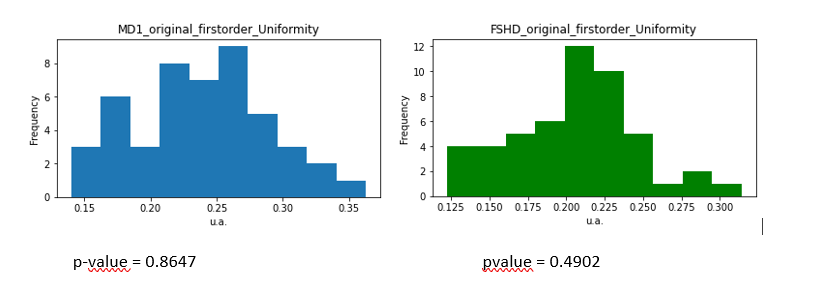

* mantengo solo le features che prese singolarmente mostrano una differenza statisticamente significativa

* pca su questo subset di features 


In [ ]:
from scipy import stats 
features_per_muscolo ={}

features_normali_per_muscolo ={}

unione_features = []

for path in df_paths:
    label = os.path.splitext(path)[0].split('_')[1]
    df = pd.read_csv(path)

    for i in range(len(feature_names)):
        print('---------------------------------------------------------------')
        print(feature_names[i])
        print(df.groupby('Class')[feature_names[i]].describe())
        
    MD1 = df[(df['Class'] == 'MD1')]
    FSHD = df[(df['Class'] == 'FSHD')]

        
        
    # two-sample wilcoxon test
    # a.k.a Mann Whitney U
    #  u, p_value = mannwhitneyu(group1, group2)

          
    feature_name_interesting = []
    for i in range(len(feature_names)):
        print('---------------------------------------------------------------')
        print(feature_names[i])
        #TEST DI WILCOXON TWO SAMPLES. Non devo verificare nè la normalità della distribuzione nè l'omogeneità della varianza  (è il corrispettivo di ttest_ind che facevo prima)
        st,pvalue = stats.mannwhitneyu(MD1[feature_names[i]], FSHD[feature_names[i]]) 

        if pvalue < 0.05:  #--> differenza significativa!
          feature_name_interesting.append(feature_names[i])
          if feature_names[i] not in unione_features:
              unione_features.append(feature_names[i])
    
    features_per_muscolo[label] = feature_name_interesting
       




Output streaming troncato alle ultime 5000 righe.
FSHD    50.0  26.010272  5.623032  13.344556  21.563713  25.657788  30.013346   
HV      10.0  19.796550  2.519992  14.121671  19.211021  20.326528  21.735258   
MD1     47.0  25.659882  6.382136  16.115423  22.444068  24.492450  28.228040   

             max  
Class             
FSHD   37.323880  
HV     22.318635  
MD1    54.372947  
---------------------------------------------------------------
original_firstorder_RootMeanSquared
       count        mean        std         min         25%         50%  \
Class                                                                     
FSHD    50.0  416.544888  21.567448  356.735674  403.032478  418.964379   
HV      10.0  423.415158  15.339756  403.202711  414.446665  418.217444   
MD1     47.0  410.972247  26.634310  354.603589  395.455824  408.555212   

              75%         max  
Class                          
FSHD   428.081395  463.831460  
HV     432.116835  454.326867  
MD1    

#Quante Principal Components?

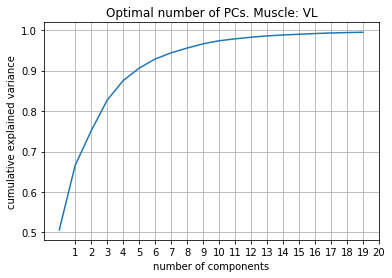

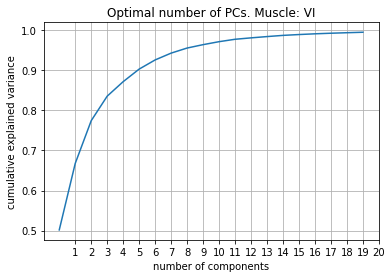

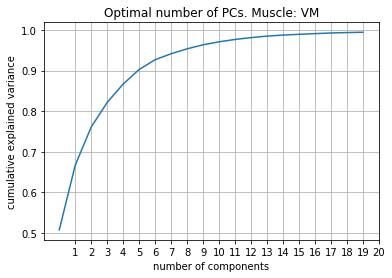

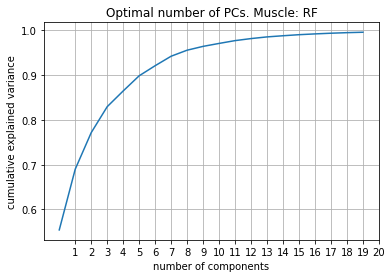

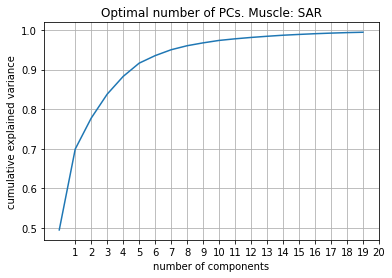

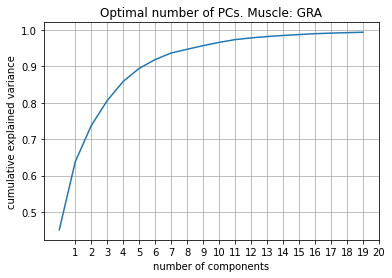

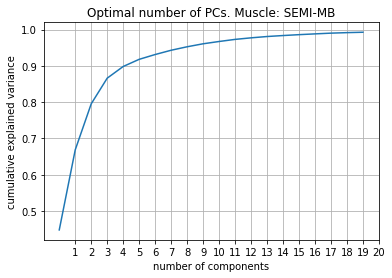

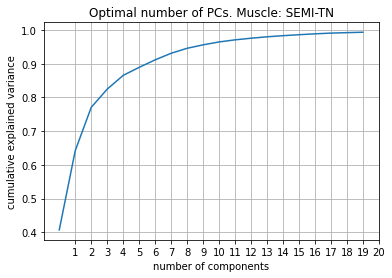

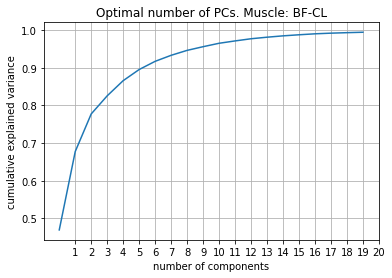

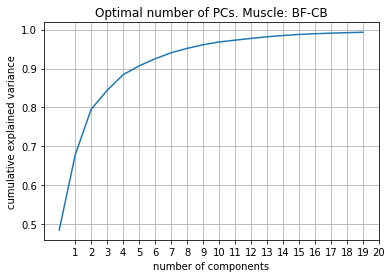

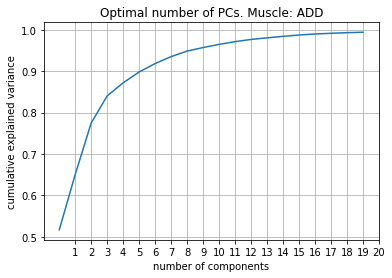

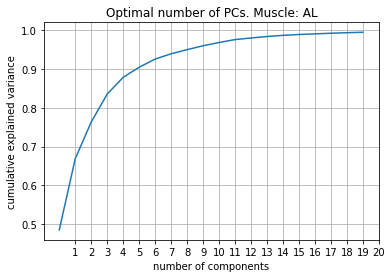

In [ ]:
y = np.arange(1,21)
#y = np.arange(1,6)

for df,label in zip(df_list,labels):  #per come l'ho costruita, df_list segue lo stesso ordine di labels
  
  data_subset = df[features_per_muscolo[label]].values
  #data_subset_scaled = StandardScaler().fit_transform(data_subset)
  data_subset_scaled = MinMaxScaler().fit_transform(data_subset)

  pca = PCA(n_components = 20).fit(data_subset_scaled)  #per prova uso un numero molto più grande di pca

  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xticks(y)
  plt.title('Optimal number of PCs. Muscle: {}'.format(label))
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance')
  plt.grid()
  plt.show()


#PCA con le features estratte

In [ ]:
      
pca_results = {}

for path in df_paths:
    label = os.path.splitext(path)[0].split('_')[1]
    df = pd.read_csv(path)
    
    df_ridotto = df[features_per_muscolo[label]]
    
    data_subset = df_ridotto.values  
    data_subset_scaled = MinMaxScaler().fit_transform(data_subset)   #normalizzo le variabili perchè PCA risente della scala. 
  
    pca = PCA(n_components = 2)
    pca_results_2d = pca.fit_transform(data_subset_scaled)   #ottengo 3 principal components
    pca_results[label] = pca_results_2d  


In [ ]:
#%%=============================================================================
#                   FEATURES PIU' RAPPRESENTATIVE E PCA
#===============================================================================
#FEATURES PIU' RILEVANTI =! PRINCIPAL COMPONENTS

#Features rilevanti --> sono un sottoinsieme delle features di partenza e sono semplicemente quelle che pesano 
#                       maggiormente nella combinazione lineare per ottenere PCi
#Principal components --> il loro numero lo decidiamo noi e permettono di rappresentare in maniera più semplice i dati
#                         ottimizzando la combinazione delle features di partenza in modo da mantenere la maggior
#                         parte delle informazioni iniziali.

relevant_features_PC1 = {}
relevant_features_PC2 = {}


#pca_results_list = []


for path in df_paths:
  label = os.path.splitext(path)[0].split('_')[1]
  df = pd.read_csv(path)

  data_subset = df[features_per_muscolo[label]].values
  #data_subset_scaled = StandardScaler().fit_transform(data_subset)
  data_subset_scaled = MinMaxScaler().fit_transform(data_subset)   #normalizzo le variabili perchè PCA risente della scala. 
  
  pca = PCA(n_components = 2)
  pca_results_2d = pca.fit_transform(data_subset_scaled)   #ottengo 3 principal components
  #pca_results_list.append(pca_results_2d)
  #-----------------Organizzazione utile per le relevant components-------------
  pca_df = pd.DataFrame(
    data=pca_results_2d, 
    columns=['PC1', 'PC2'])
  pca_df['Class'] = df['Class']
  # Principal components correlation coefficients
  loadings = pca.components_   #coefficienti autovettori
 
  # Number of features before PCA
  n_features = pca.n_features_
 
  # PC names
  pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]
 
  # Match PC names to loadings
  pc_loadings = dict(zip(pc_list, loadings))
 
  # Dataframe con features e rispettivi pesi per ogni PC
  loadings_df = pd.DataFrame.from_dict(pc_loadings)
  loadings_df['feature_names'] = features_per_muscolo[label]
  loadings_df = loadings_df.set_index('feature_names')

  #per ogni dataframe (relativo ad un muscolo) estraggo le features più rilevanti e le metto nel dict
  #Criterio di estrazione:
  #considero il peso massimo (max(loadings_df['PCi']))
  #estraggo tutte le features associate ai pesi più elevati (ovvero maggiori di (peso_massimo - delta_piccolo))
  relevant_features_PC1[label] =  loadings_df.loc[loadings_df['PC1']>max(loadings_df['PC1'])-0.05,['PC1']]
  relevant_features_PC2[label] =  loadings_df.loc[loadings_df['PC2']>max(loadings_df['PC2'])-0.05,['PC2']]
  #relevant_features_PC3[label] =  loadings_df.loc[loadings_df['PC3']>max(loadings_df['PC3'])-0.05,['PC3']]
  #-----------------------------------------------------------------------------

  #da 86 features passo a 3 principal components. Quanta informazione perdo? --> explained_variance_ratio_
  print('PCA 2 components explained variance : ',pca.explained_variance_ratio_)
  print('Cumulative explained variation for 2 principal components: ',np.sum(pca.explained_variance_ratio_)) 

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/pytho

PCA 2 components explained variance :  [0.50605682 0.1601698 ]
Cumulative explained variation for 2 principal components:  0.6662266184251869
PCA 2 components explained variance :  [0.50172871 0.1660236 ]
Cumulative explained variation for 2 principal components:  0.6677523042654754
PCA 2 components explained variance :  [0.50721885 0.15947234]
Cumulative explained variation for 2 principal components:  0.6666911920247454
PCA 2 components explained variance :  [0.55432761 0.13566514]
Cumulative explained variation for 2 principal components:  0.689992744386729
PCA 2 components explained variance :  [0.49481922 0.20424033]
Cumulative explained variation for 2 principal components:  0.6990595471205018
PCA 2 components explained variance :  [0.45095996 0.18687036]
Cumulative explained variation for 2 principal components:  0.6378303162471447
PCA 2 components explained variance :  [0.4478732  0.22080849]
Cumulative explained variation for 2 principal components:  0.6686816897167046
PCA 2 c

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
for i,muscle in enumerate(labels):
  print(muscle)
  print(relevant_features_PC1[muscle])
  print('---------------------------------------------------')
  print('Number of most relevant features: ',relevant_features_PC1[muscle].shape[0])

VL
                                                      PC1
feature_names                                            
original_glcm_DifferenceAverage                  0.194677
original_glcm_DifferenceEntropy                  0.199512
original_glcm_Imc1                               0.228506
original_gldm_SmallDependenceEmphasis            0.186427
original_glrlm_RunLengthNonUniformityNormalized  0.213650
original_glrlm_RunPercentage                     0.227057
original_glrlm_ShortRunEmphasis                  0.211743
---------------------------------------------------
Number of most relevant features:  7
VI
                                                      PC1
feature_names                                            
original_glcm_DifferenceEntropy                  0.175662
original_glcm_Imc1                               0.206969
original_gldm_DependenceNonUniformityNormalized  0.177412
original_glrlm_RunLengthNonUniformityNormalized  0.208313
original_glrlm_RunPercentage       

In [ ]:
for i,muscle in enumerate(labels):
  print(muscle)
  print(relevant_features_PC2[muscle])
  print('---------------------------------------------------')
  print('Number of most relevant features: ',relevant_features_PC2[muscle].shape[0])

VL
                                      PC2
feature_names                            
original_firstorder_Entropy      0.291463
original_glcm_SumEntropy         0.286744
original_gldm_DependenceEntropy  0.242021
---------------------------------------------------
Number of most relevant features:  3
VI
                                                         PC2
feature_names                                               
original_firstorder_Kurtosis                        0.256604
original_glcm_MaximumProbability                    0.302795
original_gldm_LargeDependenceHighGrayLevelEmphasis  0.255797
---------------------------------------------------
Number of most relevant features:  3
VM
                                                      PC2
feature_names                                            
original_firstorder_Entropy                      0.179366
original_firstorder_MeanAbsoluteDeviation        0.180610
original_firstorder_RobustMeanAbsoluteDeviation  0.163108
original

#Elimino gli outliers

In [ ]:
zoom_in_percentile_range = (0, 99)
df_plot_list = []

# for path in df_paths:
    
#     label = os.path.splitext(path)[0].split('_')[1]
#     df = pd.read_csv(path)#df mi interessa solo per la colonna delle classi
for df,label in zip(df_list,labels):
    
     
    X = pca_results[label]
    cutoffs_0 = np.percentile(X[:, 0], zoom_in_percentile_range)
    cutoffs_1 = np.percentile(X[:, 1], zoom_in_percentile_range)
    #cutoffs_2 = np.percentile(X[:, 2], zoom_in_percentile_range)


    no_outliers_mask = np.all(X > [cutoffs_0[0], cutoffs_1[0]], axis=1) & np.all(
            X < [cutoffs_0[1], cutoffs_1[1]], axis=1)

    pca_results_no_outliers = X[no_outliers_mask]

    #creo un dataframe con pca_results_no_outliers e le classi corrispondenti

    df_plot = pd.DataFrame(pca_results_no_outliers,columns=['pca_1','pca_2'])
    df_plot['Class'] = (df['Class'].values)[no_outliers_mask]
    df_plot_list.append(df_plot)
    #df plot segue lo stesso ordine di df_path quindi parte dal ADD


#VISUALIZZAZIONE

In [ ]:
    
for df_plot,label,muscle in zip(df_plot_list,labels,thigh_muscles):
    #label = os.path.splitext(path)[0].split('_')[1]
    fig = px.scatter(
                df_plot, x= 'pca_1', y= 'pca_2',
                color= 'Class', labels={'color': 'Class'},width = 10,height = 10)
    fig.update_layout(legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01))
    fig.update_traces(marker_size=16)
    title = (muscle  + '({})'.format(label) + ' Mann-Whitney  U test , N_features = {}'.format(len(features_per_muscolo[label])) )
    
    fig.update_layout(title= title, width=1400, height=500)

    fig.show()